# Extracting Delta-PDF maps from diffuse scattering

In [2]:
from nxs_analysis_tools import *
from nxs_analysis_tools.datasets import vacancies
from nxs_analysis_tools.datareduction import load_discus_nxs

data_path = vacancies()

import matplotlib.pyplot as plt

Here we showcase the use of the `DeltaPDF` class found in the `pairdistribution` module of the `nxs-analysis-tools` package. For the example data, we consider a model structure of Cu where there are 3% vacancies. These vacancies cause the surrounding atoms along the 100-type directions to relax by 15% of the interatomic spacing towards the vacancy. A representative plane is shown below:

<img src="https://github.com/stevenjgomez/dataset-vacancies/blob/main/vacancies.png?raw=true" alt="Vacancies Image">


## Visualizing the diffuse scattering data

First let's load the example dataset:

In [3]:
data = load_discus_nxs(data_path)

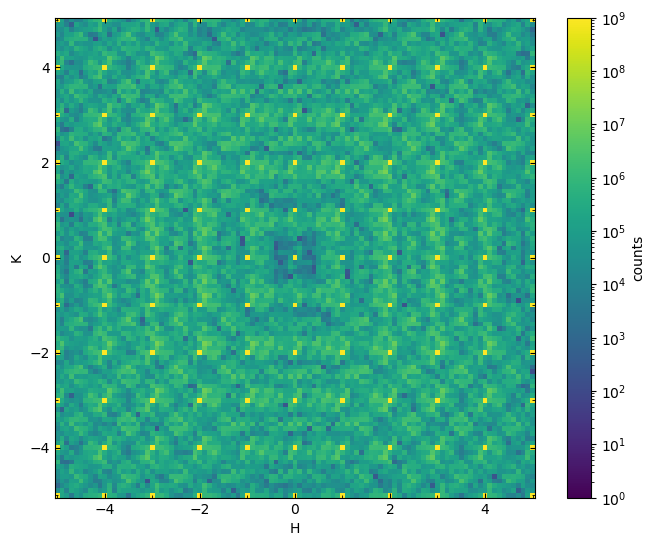

In [4]:
plot_slice(data[:,:,0.0], vmin=1, vmax=1e9, logscale=True)

## Importing the `DeltaPDF` class

Clearly, there is evidence for diffuse scattering in the background of the usual Bragg reflections. This is the perfect use case to apply the DeltaPDF technique. To facilitate this, we import the `DeltaPDF` object:

In [5]:
from nxs_analysis_tools.pairdistribution import DeltaPDF

We'll initialize an object called `dpdf` which will be an instance of the `DeltaPDF` class, allowing us to use the tools stored in this class.

In [6]:
dpdf = DeltaPDF()

## Step 1: Setup the data and lattice information

First, we set the data to be transformed:

In [7]:
dpdf.set_data(data)

Next, we set the lattice parameters. Here we assume a cubic cell with lattice parameter of 5 Angstroms.

In [8]:
dpdf.set_lattice_params((5,5,5,90,90,90))

## Step 2: Generate a mask for Bragg peaks and unwanted pixels

For removal of well-defined Bragg peaks, one can usually create a mask of spheres or ellipsoids around the integer Bragg positions. This can be done using the `.generate_bragg_mask()` method.

First, we examine the case of spheres around each integer coordinate. Simply specify a `punch_radius` in lattice units to remove from the dataset, and a mask will be generated accordingly.

In [9]:
mask = dpdf.generate_bragg_mask(punch_radius=0.2)

Let's visualize a cross section of the mask:

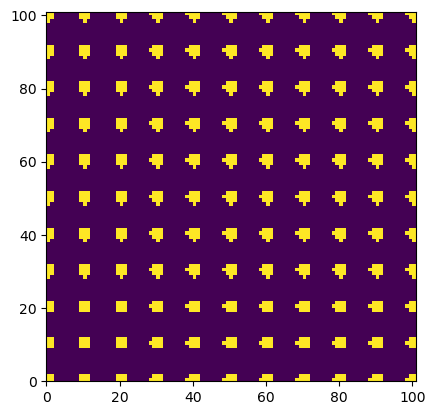

In [10]:
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())

# Set aspect ratio to the lattice parameter ratio b/a
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

Sometimes it is useful to create ellipsoids rather than spheres. For this purpose, you may specify coefficients using the `coeffs` parameter to modify the H^2, HK, K^2, KL, L^2, and LH terms of the ellipsoid equation, respectively. The default is `coeffs=[1,0,1,0,1,0]` (i.e., no cross terms). If I want to create an ellipsoid that is elongated along the K axis, I can do so by changing the coefficients as follows:

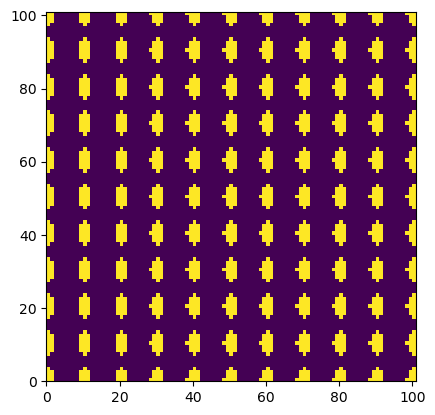

In [11]:
mask = dpdf.generate_bragg_mask(punch_radius=0.2, coeffs=[1,0,0.4,0,1,0])
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

Likewise, if I need the ellipsoids to elongate diagonally, I can add a non-zero cross term in the HK direction.

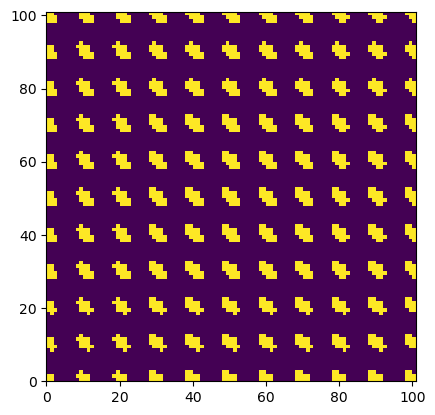

In [12]:
mask = dpdf.generate_bragg_mask(punch_radius=0.2, coeffs=[1,1,1,0,1,0])
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

In addition, the `thresh` parameter can be used to define a threshold intensity within these ellipsoids, such that pixels below this threshold are kept and pixels above the threshold are removed. For example:

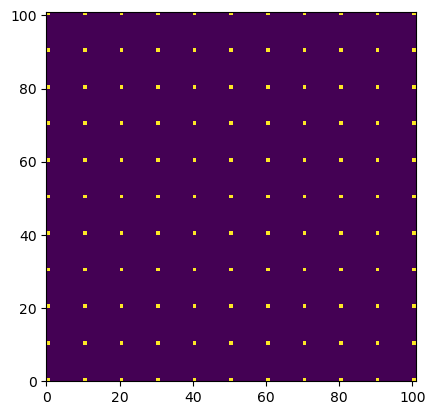

In [13]:
mask = dpdf.generate_bragg_mask(punch_radius=0.2, thresh=1e9)
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

Another option for masking pixels is to use the `.generate_intensity_mask()` method to mask out ALL pixels above a certain threshold, including a small chosen radius (in px) of surrounding pixels.

Shape of data is (101, 101, 101)
Found high intensity at (100, 100, 100).		
Done.


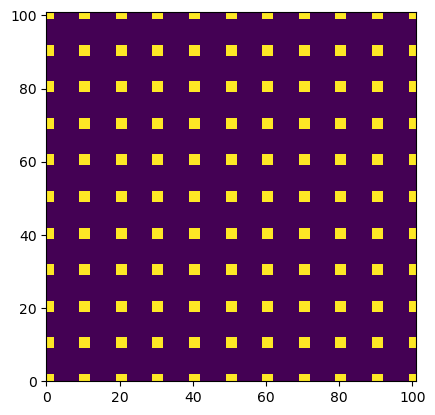

In [14]:
mask = dpdf.generate_intensity_mask(thresh=1e9, radius=1)
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

Lastly, there is the option to generate an ellipsoid as described earlier, but at a general coordinate using `.generate_mask_at_coord()`.

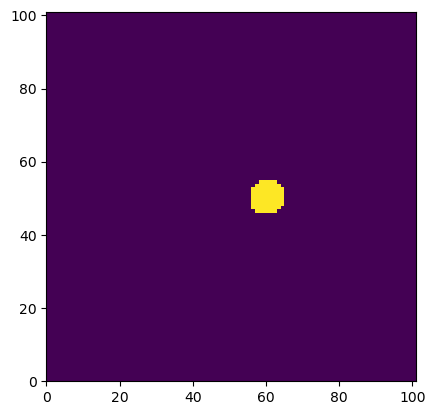

In [15]:
mask = dpdf.generate_mask_at_coord(coordinate=(1,0,0), punch_radius=0.5)
plt.pcolormesh(mask[:,:,mask.shape[2]//2].transpose())
plt.gca().set_aspect(dpdf.lattice_params[1]/dpdf.lattice_params[0])

The same `coeffs` and `thresh` can be specified for this method as well.

To formally set the mask to use for the punching operation, one must use the `.add_mask()` method. This can be used in conjunction with the`.subtract_mask()` method to generate complex and custom masks.

For now, we will use the standard Bragg mask of spheres around each Bragg reflection.

In [16]:
mask = dpdf.generate_bragg_mask(punch_radius=0.2)
dpdf.add_mask(mask)

To apply the mask to the data, use the `.punch()` method.

In [17]:
dpdf.punch()

The punched data is then stored in the `.punched` attribute.

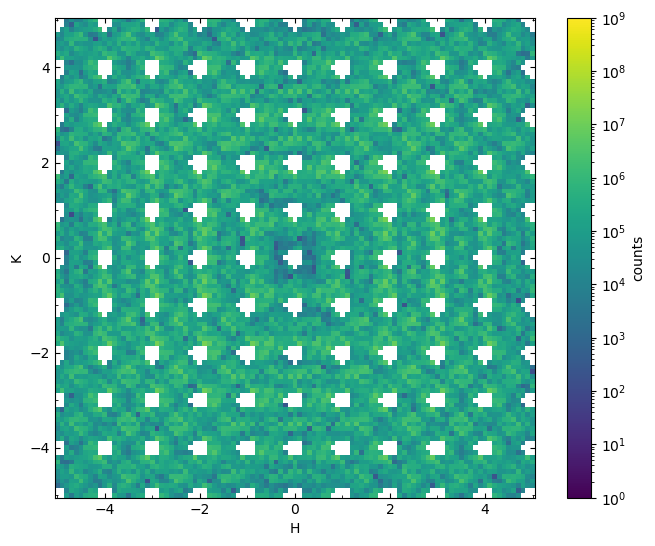

In [18]:
plot_slice(dpdf.punched[:,:,0.0], vmin=1, vmax=1e9, logscale=True)

## Step 3: Fill in missing data

Filling in the resulting gaps in the data requires convolution with a Gaussian kernel, effectively interpolating the missing data using surrounding values.

First, we set a kernel using the `.set_kernel()` method. Here we call the built-in `Gaussian3DKernel` function, which provides a 3D Gaussian shape that can be modified using the `coeffs` parameter to become an ellipsoid as described above. Here we choose a standard deviation of 1 and a size of 10x10x10 cubic pixels.

In [19]:
from nxs_analysis_tools.pairdistribution import Gaussian3DKernel
dpdf.set_kernel(Gaussian3DKernel(stddev=1, size=(10,10,10)))                                                                                                           

It may be insightful at this point to visualize the kernel to get an idea for its size relative to the dataset. Use the `imshow` function from `matplotlib` to get an apples to apples comparison of the dimensions of these two objects.

[(0.0, 50.0), (0.0, 50.0)]

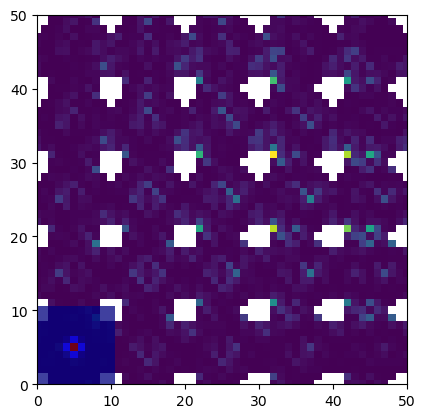

In [40]:
fig,ax = plt.subplots() # Create a common figure and axes to plot on
ax.imshow(dpdf.punched[:,:,0.0].nxsignal.nxdata, cmap='viridis') # Plot the punched data
ax.imshow(dpdf.kernel.array[:,:,dpdf.kernel.array.shape[2]//2], alpha=0.75, cmap='jet') # Plot a cross section of the kernel
ax.set(xlim=(0,50), ylim=(0,50)) # Zoom into the corner where the kernel is plotted

To perform the interpolation, use the `.interpolate()` method.

In [87]:
dpdf.interpolate()

Running interpolation...
Interpolation finished.
Interpolation took 0.01 minutes.


The results are stored in the `.interpolated` attribute:

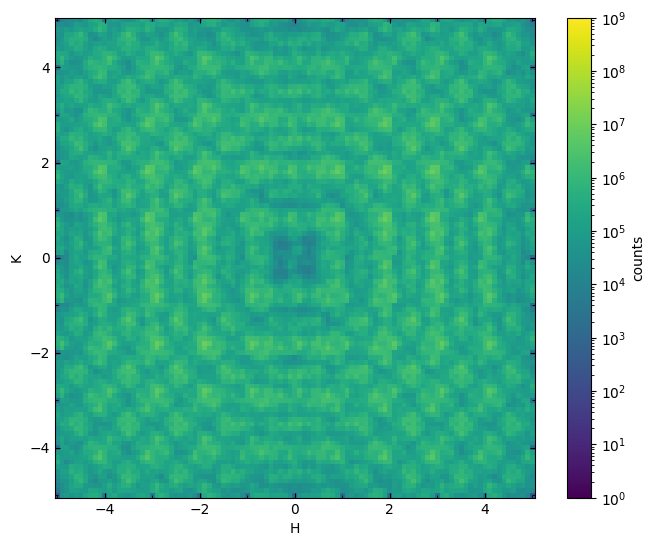

In [88]:
plot_slice(dpdf.interpolated[:,:,0.0], vmin=1, vmax=1e9, logscale=True)

## Step 4: Taper edges of data

Now that we have successfully isolated the diffuse scattering, the edges of the data must be tapered to a zero value in order to avoid cutoff artifacts (ripples) after the Fourier transform.

Two built-in options for tapering windows are provided: `.set_tukey_window()` and `.set_hexagonal_tukey_window()`. The first applies a standard tukey window from the `scipy` package along H, K, and L, while the second applies a hexagonal tukey window in the HK plane and a standard tukey window along L.

In [89]:
dpdf.set_tukey_window()

The chosen window is stored in the `.window` attribute:

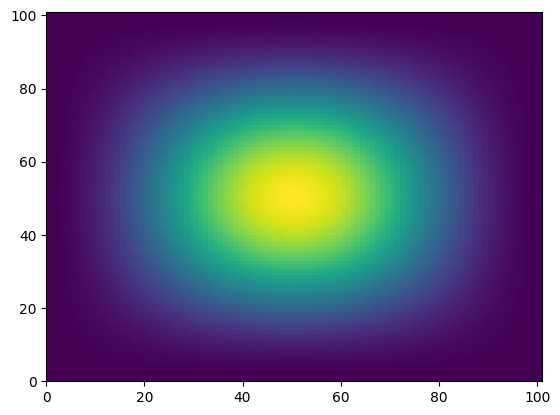

In [90]:
plt.pcolormesh(dpdf.window[:,:,data.shape[2]//2], vmin=0, vmax=1)

The optional `tukey_alphas` parameter allows the user to provide a tuple of values for the tukey alpha to be applied along each direction. For the `.set_tukey_window()` method, a three-tuple should be provided (e.g., (0.5,0.5,0.5)) corresponding to H, K, and L directions. For the `.set_hexagonal_tukey_window()`, a four-tuple should be provided (e.g., (0.5,0.5,0.5,0.5)) corresponding to H, K, HK, and L directions.

In [91]:
dpdf.set_tukey_window(tukey_alphas=(0.5,0.5,0.5))

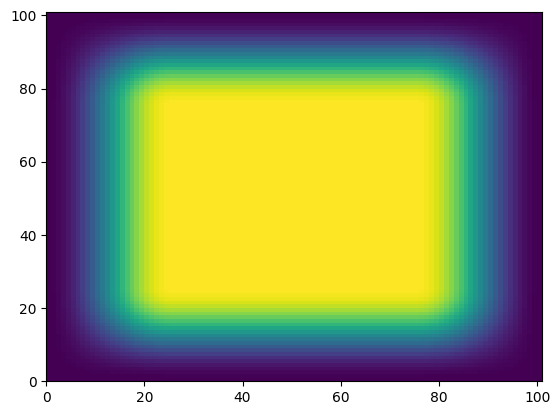

In [92]:
plt.pcolormesh(dpdf.window[:,:,data.shape[2]//2], vmin=0, vmax=1)

To apply the window to the data, use the `.apply_window()` method.

In [93]:
dpdf.set_tukey_window()
dpdf.apply_window()

The resulting tapered data is stored in the `.tapered` attribute.

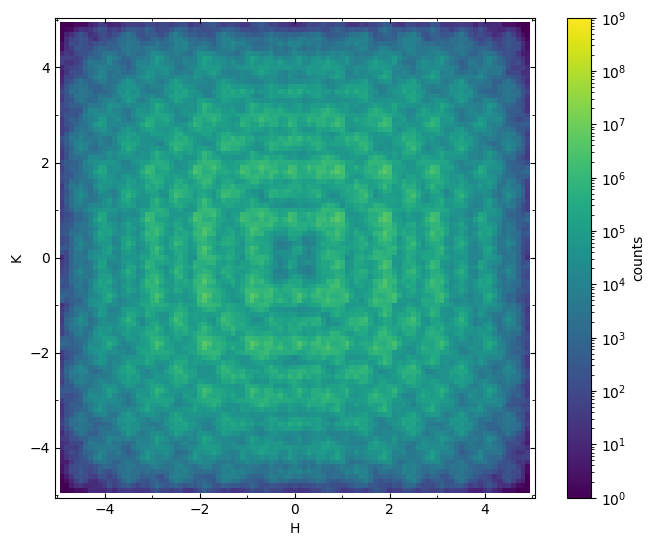

In [94]:
plot_slice(dpdf.tapered[:,:,0.0], vmin=1, vmax=1e9, logscale=True)

## Step 5: Pad data with zeros

Lastly, in order to improve the resolution of the pdf after the Fourier transform, we must pad the data with zeros around the original reciprocal space volume using the `.pad()` method. The `padding` parameter allows the user to provide a tuple of three integers to specify the number of pixels add to each side along the H, K, and L directions.

In [95]:
dpdf.pad(padding=(20,20,20))

The padded data is stored in the `.padded` attribute

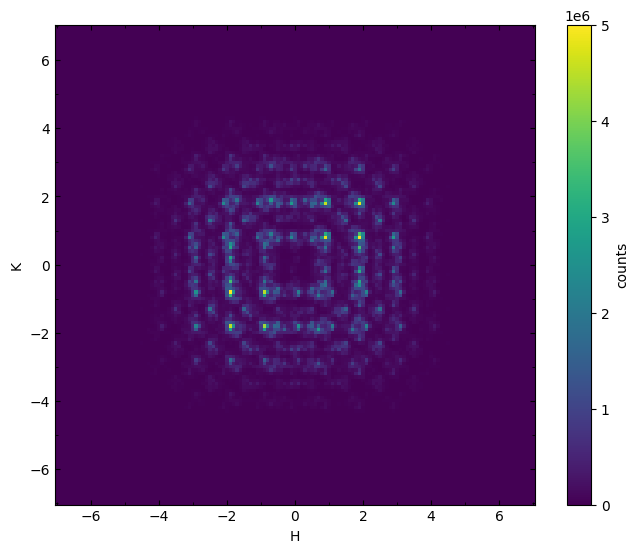

In [96]:
plot_slice(dpdf.padded[:,:,0.0], vmin=0, vmax=5e6, logscale=False)

## Step 6: Perform Fourier transform

Use the `.perform_fft()` method to begin running the Fourier transform.

In [97]:
dpdf.perform_fft()

Starting FFT.
FFT on axes 1,2
FFT on axis 3          
FFT complete.          
FFT took 3.5881030559539795 seconds.


The resulting 3D-DeltaPDF is stored in the `.fft` attribute.

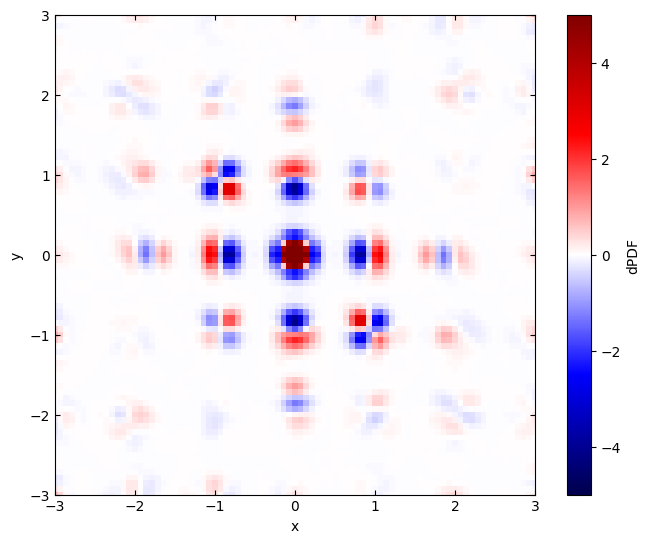

In [98]:
plot_slice(dpdf.fft[:,:,0.0]/1e3, cmap='seismic',
           vmin=-5, vmax=5,
           xlim=(-3,3),
           ylim=(-3,3),
          )